# Date encoding

In [1]:
import imp
import numpy as np
import pandas as pd
import xgboost as xgb
pd.set_option('display.max_columns', None)
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.base import BaseEstimator
import xgboost as xgb
plt.rcParams['figure.figsize'] = [20, 20]

In [2]:
problem = imp.load_source('', 'problem.py')
X_df, y_array = problem.get_train_data()
X_df.head()

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,std_wtd
0,2012-06-19,ORD,DFW,12.875000,9.812647
1,2012-09-10,LAS,DEN,14.285714,9.466734
2,2012-10-05,DEN,LAX,10.863636,9.035883
3,2011-10-09,ATL,ORD,11.480000,7.990202
4,2012-02-21,DEN,SFO,11.450000,9.517159


In [3]:
ext_data = pd.read_csv('submissions/starting_kit/external_data.csv', sep=';')
ext_data.head()

,Departure,Arrival,Distance,DateOfDeparture,Max TemperatureC,Mean TemperatureC,Min TemperatureC,Dew PointC,MeanDew PointC,Min DewpointC,Max Humidity,Mean Humidity,Min Humidity,Max Sea Level PressurehPa,Mean Sea Level PressurehPa,Min Sea Level PressurehPa,Max VisibilityKm,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,Max Gust SpeedKm/h,Precipitationmm,CloudCover,Events,WindDirDegrees,Number_hab,Revenue,Oil_price,dep_encod,ar_encod
0,LAS,ORD,2434,2011-09-01,34,28,22,23,22,19,84,70,56,1015,1013,1011,16,15,11,26,9,37.0,0,1,NaN,197,2712920,52273,88.930000,10.76,11.26
1,LAS,ORD,2434,2011-09-02,33,29,24,22,21,19,79,64,49,1013,1012,1011,16,15,11,27,12,37.0,0,4,NaN,215,2712920,52273,86.570000,10.76,11.26
2,LAS,ORD,2434,2011-09-03,32,26,21,22,20,18,93,70,46,1013,1012,1011,16,15,8,32,10,39.0,0.51,6,Rain-Thunderstorm,270,2712920,52273,93.794367,10.76,11.26
3,LAS,ORD,2434,2011-09-04,23,19,14,19,13,9,93,70,47,1017,1013,1010,16,16,16,35,19,45.0,0,5,NaN,312,2712920,52273,93.794367,10.76,11.26
4,LAS,ORD,2434,2011-09-05,18,15,11,10,7,6,77,64,51,1021,1020,1017,16,16,16,42,24,56.0,0,3,NaN,5,2712920,52273,83.520000,10.76,11.26


In [4]:
X_encoded = X_df
external_data = ext_data[['DateOfDeparture', 'Departure', 'Arrival', 'Distance',
                                'dep_encod', 'ar_encod', 'Mean TemperatureC',
                                'MeanDew PointC', 'Mean Humidity', 'Min VisibilitykM', 'Max Wind SpeedKm/h',
                                'Precipitationmm', 'Events', 'Number_hab', 'Revenue', 'Oil_price'
                         ]]
X_encoded = pd.merge(
            X_encoded, external_data, how='left',
            left_on=['DateOfDeparture', 'Arrival', 'Departure'],
            right_on=['DateOfDeparture', 'Arrival', 'Departure'],
            sort=False)

X_encoded.head()

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,std_wtd,Distance,dep_encod,ar_encod,Mean TemperatureC,MeanDew PointC,Mean Humidity,Min VisibilitykM,Max Wind SpeedKm/h,Precipitationmm,Events,Number_hab,Revenue,Oil_price
0,2012-06-19,ORD,DFW,12.875000,9.812647,1292,11.27,11.08,29,21,63,16,48,0,NaN,1241700,45616,84.030000
1,2012-09-10,LAS,DEN,14.285714,9.466734,1010,10.76,10.69,25,-6,14,16,35,0,NaN,634542,52262,96.540000
2,2012-10-05,DEN,LAX,10.863636,9.035883,1387,10.68,11.43,19,16,77,8,24,0,Fog,3852782,57739,89.960000
3,2011-10-09,ATL,ORD,11.480000,7.990202,977,11.00,11.26,19,10,58,16,23,0,NaN,2712920,52273,93.794367
4,2012-02-21,DEN,SFO,11.450000,9.517159,1554,10.68,11.23,12,8,79,3,24,0,NaN,827420,57739,106.250000


In [5]:
X_encoded = X_encoded.join(pd.get_dummies(X_encoded['Departure']))
X_encoded = X_encoded.join(pd.get_dummies(X_encoded['Arrival'], prefix='a'))
X_encoded = X_encoded.drop('Departure', axis=1)
X_encoded = X_encoded.drop('Arrival', axis=1)

X_encoded.loc[:, 'ATL': 'SFO'] = X_encoded.loc[:, 'ATL': 'SFO'].mul(X_encoded.loc[:, 'dep_encod'], axis='rows')
arr = X_encoded.loc[:, 'a_ATL': 'a_SFO'].mul(- 1 * X_encoded.loc[:, 'ar_encod'], axis='rows')

arr.columns = X_encoded.loc[:, 'ATL': 'SFO'].columns
X_encoded.loc[:, 'ATL': 'SFO'] = X_encoded.loc[:, 'ATL': 'SFO'].add(arr, axis=1)

X_encoded.drop(['dep_encod', 'ar_encod'], axis=1, inplace=True)
X_encoded.drop(X_encoded.loc[:, 'a_ATL': 'a_SFO'].columns, axis=1, inplace=True)
X_encoded.head()

,DateOfDeparture,WeeksToDeparture,std_wtd,Distance,Mean TemperatureC,MeanDew PointC,Mean Humidity,Min VisibilitykM,Max Wind SpeedKm/h,Precipitationmm,Events,Number_hab,Revenue,Oil_price,ATL,BOS,CLT,DEN,DFW,DTW,EWR,IAH,JFK,LAS,LAX,LGA,MCO,MIA,MSP,ORD,PHL,PHX,SEA,SFO
0,2012-06-19,12.875000,9.812647,1292,29,21,63,16,48,0,NaN,1241700,45616,84.030000,0.0,0.0,0.0,0.00,-11.08,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,11.27,0.0,0.0,0.0,0.00
1,2012-09-10,14.285714,9.466734,1010,25,-6,14,16,35,0,NaN,634542,52262,96.540000,0.0,0.0,0.0,-10.69,0.00,0.0,0.0,0.0,0.0,10.76,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00
2,2012-10-05,10.863636,9.035883,1387,19,16,77,8,24,0,Fog,3852782,57739,89.960000,0.0,0.0,0.0,10.68,0.00,0.0,0.0,0.0,0.0,0.00,-11.43,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00
3,2011-10-09,11.480000,7.990202,977,19,10,58,16,23,0,NaN,2712920,52273,93.794367,11.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,-11.26,0.0,0.0,0.0,0.00
4,2012-02-21,11.450000,9.517159,1554,12,8,79,3,24,0,NaN,827420,57739,106.250000,0.0,0.0,0.0,10.68,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,-11.23


In [6]:
def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

In [7]:
X_encoded['DateOfDeparture'] = pd.to_datetime(X_encoded['DateOfDeparture'])
X_encoded['year'] = X_encoded['DateOfDeparture'].dt.year
X_encoded['month'] = X_encoded['DateOfDeparture'].dt.month
X_encoded['day'] = X_encoded['DateOfDeparture'].dt.day
X_encoded['weekday'] = X_encoded['DateOfDeparture'].dt.weekday
X_encoded['week'] = X_encoded['DateOfDeparture'].dt.week
X_encoded['n_days'] = X_encoded['DateOfDeparture'].apply(lambda date: (date - pd.to_datetime("1970-01-01")).days)
X_encoded.head()

,DateOfDeparture,WeeksToDeparture,std_wtd,Distance,Mean TemperatureC,MeanDew PointC,Mean Humidity,Min VisibilitykM,Max Wind SpeedKm/h,Precipitationmm,Events,Number_hab,Revenue,Oil_price,ATL,BOS,CLT,DEN,DFW,DTW,EWR,IAH,JFK,LAS,LAX,LGA,MCO,MIA,MSP,ORD,PHL,PHX,SEA,SFO,year,month,day,weekday,week,n_days
0,2012-06-19,12.875000,9.812647,1292,29,21,63,16,48,0,NaN,1241700,45616,84.030000,0.0,0.0,0.0,0.00,-11.08,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,11.27,0.0,0.0,0.0,0.00,2012,6,19,1,25,15510
1,2012-09-10,14.285714,9.466734,1010,25,-6,14,16,35,0,NaN,634542,52262,96.540000,0.0,0.0,0.0,-10.69,0.00,0.0,0.0,0.0,0.0,10.76,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,2012,9,10,0,37,15593
2,2012-10-05,10.863636,9.035883,1387,19,16,77,8,24,0,Fog,3852782,57739,89.960000,0.0,0.0,0.0,10.68,0.00,0.0,0.0,0.0,0.0,0.00,-11.43,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,2012,10,5,4,40,15618
3,2011-10-09,11.480000,7.990202,977,19,10,58,16,23,0,NaN,2712920,52273,93.794367,11.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,-11.26,0.0,0.0,0.0,0.00,2011,10,9,6,40,15256
4,2012-02-21,11.450000,9.517159,1554,12,8,79,3,24,0,NaN,827420,57739,106.250000,0.0,0.0,0.0,10.68,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,-11.23,2012,2,21,1,8,15391


In [8]:
X_encoded = encode(X_encoded, 'month', 12)
X_encoded = encode(X_encoded, 'week', 52)
X_encoded = encode(X_encoded, 'day', 365)
X_encoded = encode(X_encoded, 'weekday', 6)

In [9]:
X_encoded = X_encoded.drop(['DateOfDeparture', 'year', 'month', 'day', 'weekday', 'week'], axis=1)
X_encoded.head()

,WeeksToDeparture,std_wtd,Distance,Mean TemperatureC,MeanDew PointC,Mean Humidity,Min VisibilitykM,Max Wind SpeedKm/h,Precipitationmm,Events,Number_hab,Revenue,Oil_price,ATL,BOS,CLT,DEN,DFW,DTW,EWR,IAH,JFK,LAS,LAX,LGA,MCO,MIA,MSP,ORD,PHL,PHX,SEA,SFO,n_days,month_sin,month_cos,week_sin,week_cos,day_sin,day_cos,weekday_sin,weekday_cos
0,12.875000,9.812647,1292,29,21,63,16,48,0,NaN,1241700,45616,84.030000,0.0,0.0,0.0,0.00,-11.08,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,11.27,0.0,0.0,0.0,0.00,15510,1.224647e-16,-1.000000e+00,0.120537,-0.992709,0.321270,0.946988,8.660254e-01,0.5
1,14.285714,9.466734,1010,25,-6,14,16,35,0,NaN,634542,52262,96.540000,0.0,0.0,0.0,-10.69,0.00,0.0,0.0,0.0,0.0,10.76,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,15593,-1.000000e+00,-1.836970e-16,-0.970942,-0.239316,0.171293,0.985220,0.000000e+00,1.0
2,10.863636,9.035883,1387,19,16,77,8,24,0,Fog,3852782,57739,89.960000,0.0,0.0,0.0,10.68,0.00,0.0,0.0,0.0,0.0,0.00,-11.43,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,15618,-8.660254e-01,5.000000e-01,-0.992709,0.120537,0.085965,0.996298,-8.660254e-01,-0.5
3,11.480000,7.990202,977,19,10,58,16,23,0,NaN,2712920,52273,93.794367,11.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,-11.26,0.0,0.0,0.0,0.00,15256,-8.660254e-01,5.000000e-01,-0.992709,0.120537,0.154309,0.988023,-2.449294e-16,1.0
4,11.450000,9.517159,1554,12,8,79,3,24,0,NaN,827420,57739,106.250000,0.0,0.0,0.0,10.68,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,-11.23,15391,8.660254e-01,5.000000e-01,0.822984,0.568065,0.353676,0.935368,8.660254e-01,0.5


In [10]:
from sklearn.decomposition import PCA 
from sklearn import preprocessing

reserv = preprocessing.scale(X_encoded.loc[:, 'WeeksToDeparture' : 'std_wtd'])
meteo = preprocessing.scale(X_encoded.loc[:, 'Mean TemperatureC' : 'Max Wind SpeedKm/h'])
pca = PCA(n_components=1)
reserv = pca.fit_transform(reserv)

pca = PCA(n_components=2)
meteo = pca.fit_transform(meteo)

In [13]:
meteo = pd.DataFrame(data = meteo, columns = ['Princ. Comp. ' + str(i) for i in range(2)])

X_encoded = pd.concat([X_encoded, meteo], axis = 1)
X_encoded['reserv'] = reserv
X_encoded.head()

,WeeksToDeparture,std_wtd,Distance,Mean TemperatureC,MeanDew PointC,Mean Humidity,Min VisibilitykM,Max Wind SpeedKm/h,Precipitationmm,Events,Number_hab,Revenue,Oil_price,ATL,BOS,CLT,DEN,DFW,DTW,EWR,IAH,JFK,LAS,LAX,LGA,MCO,MIA,MSP,ORD,PHL,PHX,SEA,SFO,n_days,month_sin,month_cos,week_sin,week_cos,day_sin,day_cos,weekday_sin,weekday_cos,Princ. Comp. 0,Princ. Comp. 1,reserv
0,12.875000,9.812647,1292,29,21,63,16,48,0,NaN,1241700,45616,84.030000,0.0,0.0,0.0,0.00,-11.08,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,11.27,0.0,0.0,0.0,0.00,15510,1.224647e-16,-1.000000e+00,0.120537,-0.992709,0.321270,0.946988,8.660254e-01,0.5,-1.266405,-1.608790,0.757354
1,14.285714,9.466734,1010,25,-6,14,16,35,0,NaN,634542,52262,96.540000,0.0,0.0,0.0,-10.69,0.00,0.0,0.0,0.0,0.0,10.76,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,15593,-1.000000e+00,-1.836970e-16,-0.970942,-0.239316,0.171293,0.985220,0.000000e+00,1.0,2.086817,-2.149769,1.000951
2,10.863636,9.035883,1387,19,16,77,8,24,0,Fog,3852782,57739,89.960000,0.0,0.0,0.0,10.68,0.00,0.0,0.0,0.0,0.0,0.00,-11.43,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,15618,-8.660254e-01,5.000000e-01,-0.992709,0.120537,0.085965,0.996298,-8.660254e-01,-0.5,-1.648635,0.096495,-0.009688
3,11.480000,7.990202,977,19,10,58,16,23,0,NaN,2712920,52273,93.794367,11.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,-11.26,0.0,0.0,0.0,0.00,15256,-8.660254e-01,5.000000e-01,-0.992709,0.120537,0.154309,0.988023,-2.449294e-16,1.0,-0.170266,-1.078849,-0.198907
4,11.450000,9.517159,1554,12,8,79,3,24,0,NaN,827420,57739,106.250000,0.0,0.0,0.0,10.68,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,-11.23,15391,8.660254e-01,5.000000e-01,0.822984,0.568065,0.353676,0.935368,8.660254e-01,0.5,-1.159485,1.325257,0.298146


In [14]:
X_encoded['Precipitationmm'] = X_encoded['Precipitationmm'].replace('T', np.nan)
X_encoded['Precipitationmm'] = pd.to_numeric(X_encoded['Precipitationmm'])
X_encoded['Precipitationmm'] = X_encoded['Precipitationmm'].fillna(X_encoded['Precipitationmm'].mean())

X_encoded['Events'].fillna(0, inplace=True)
X_encoded['Events'] = X_encoded['Events'].replace(['Rain','Fog'], 1)
X_encoded['Events'] = X_encoded['Events'].replace(['Rain-Thunderstorm','Fog-Rain-Thunderstorm', \
                                                'Rain-Snow','Snow','Fog-Rain','Thunderstorm','Fog-Snow', \
                                                'Fog-Rain-Snow','Fog-Rain-Snow-Thunderstorm', \
                                                'Rain-Snow-Thunderstorm','Rain-Hail-Thunderstorm', \
                                                'Fog-Rain-Hail-Thunderstorm', \
                                                'Rain-Thunderstorm-Tornado'], 2)

In [15]:
X_encoded.drop(['WeeksToDeparture', 'std_wtd', 'Mean TemperatureC',
                'MeanDew PointC', 'Mean Humidity', 'Min VisibilitykM',
                'Max Wind SpeedKm/h',], axis=1, inplace=True)
X_encoded.head()

,Distance,Precipitationmm,Events,Number_hab,Revenue,Oil_price,ATL,BOS,CLT,DEN,DFW,DTW,EWR,IAH,JFK,LAS,LAX,LGA,MCO,MIA,MSP,ORD,PHL,PHX,SEA,SFO,n_days,month_sin,month_cos,week_sin,week_cos,day_sin,day_cos,weekday_sin,weekday_cos,Princ. Comp. 0,Princ. Comp. 1,reserv
0,1292,0.0,0,1241700,45616,84.030000,0.0,0.0,0.0,0.00,-11.08,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,11.27,0.0,0.0,0.0,0.00,15510,1.224647e-16,-1.000000e+00,0.120537,-0.992709,0.321270,0.946988,8.660254e-01,0.5,-1.266405,-1.608790,0.757354
1,1010,0.0,0,634542,52262,96.540000,0.0,0.0,0.0,-10.69,0.00,0.0,0.0,0.0,0.0,10.76,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,15593,-1.000000e+00,-1.836970e-16,-0.970942,-0.239316,0.171293,0.985220,0.000000e+00,1.0,2.086817,-2.149769,1.000951
2,1387,0.0,1,3852782,57739,89.960000,0.0,0.0,0.0,10.68,0.00,0.0,0.0,0.0,0.0,0.00,-11.43,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,15618,-8.660254e-01,5.000000e-01,-0.992709,0.120537,0.085965,0.996298,-8.660254e-01,-0.5,-1.648635,0.096495,-0.009688
3,977,0.0,0,2712920,52273,93.794367,11.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,-11.26,0.0,0.0,0.0,0.00,15256,-8.660254e-01,5.000000e-01,-0.992709,0.120537,0.154309,0.988023,-2.449294e-16,1.0,-0.170266,-1.078849,-0.198907
4,1554,0.0,0,827420,57739,106.250000,0.0,0.0,0.0,10.68,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,-11.23,15391,8.660254e-01,5.000000e-01,0.822984,0.568065,0.353676,0.935368,8.660254e-01,0.5,-1.159485,1.325257,0.298146


In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_array, test_size=0.2, random_state=0)

xgb1 = xgb.XGBRegressor()

In [17]:
data_dmatrix = xgb.DMatrix(data=X_encoded,label=y_array)
parameters = {'nthread':1,
              'objective':'reg:squarederror',
              'learning_rate': .2, 
              'max_depth': 7,
              'min_child_weight': 4,
              'subsample': 0.95,
              'colsample_bytree': 0.55,
              'n_estimators': 1000,
              'reg_lambda':0.001,
              'gamma':0}

cv_results = xgb.cv(dtrain=data_dmatrix, params=parameters, nfold=3,
                    num_boost_round=300,early_stopping_rounds=5,metrics="rmse", as_pandas=True, seed=123)

In [18]:
print((cv_results["train-rmse-mean"]).tail(1))
print((cv_results["test-rmse-mean"]).tail(1))

163    0.120164
Name: train-rmse-mean, dtype: float64
163    0.389495
Name: test-rmse-mean, dtype: float64


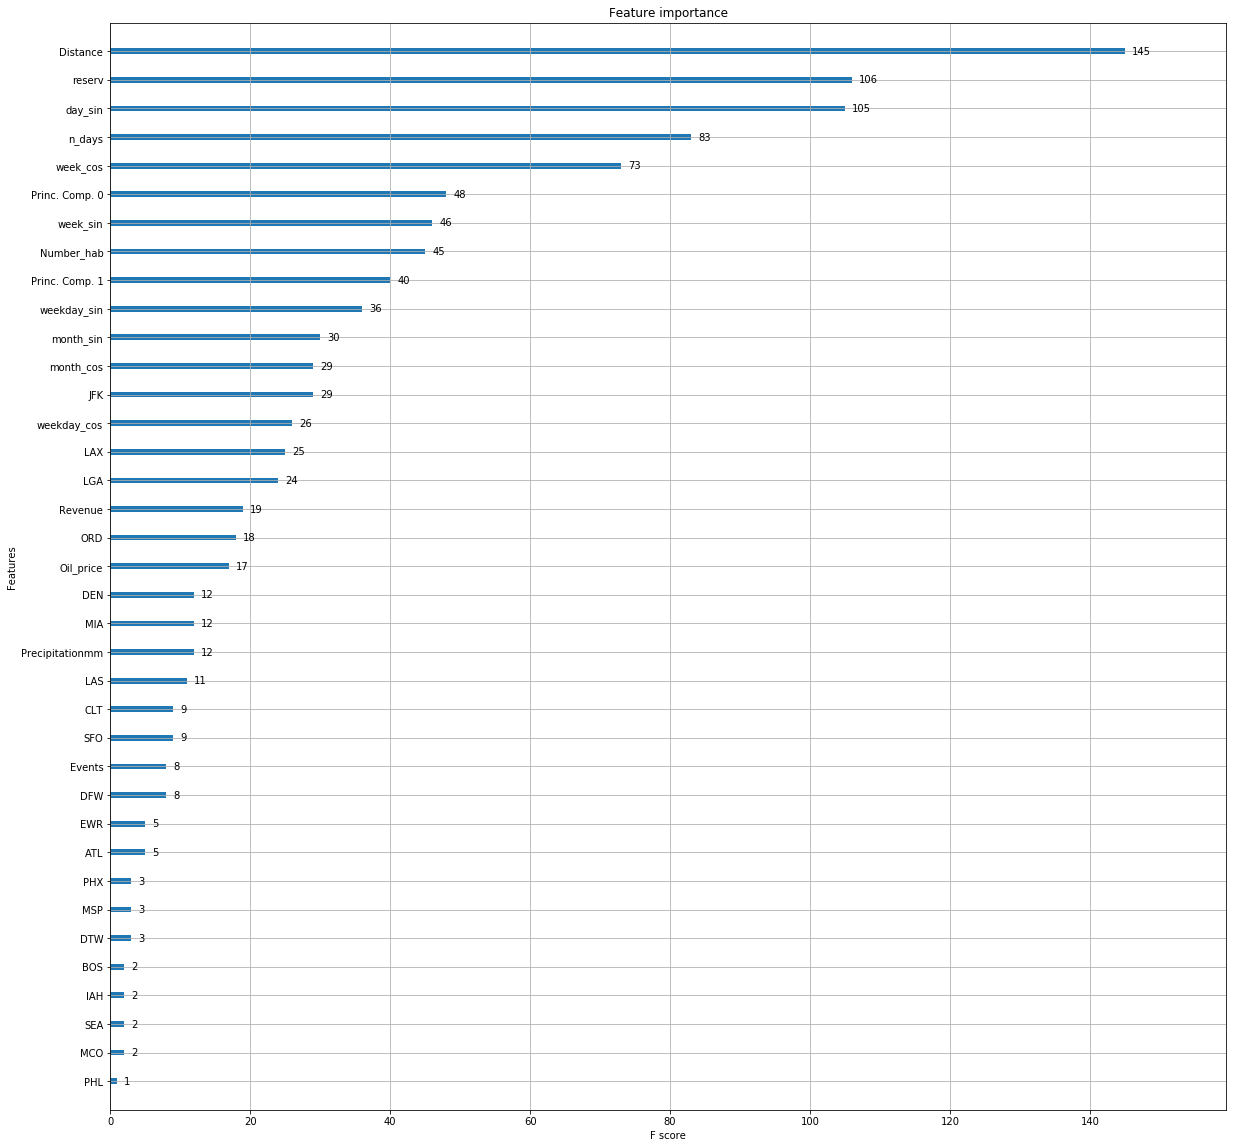

In [22]:
xg_reg = xgb.train(params=parameters, dtrain=data_dmatrix, num_boost_round=10)
xgb.plot_importance(xg_reg, max_num_features=40)
plt.rcParams['figure.figsize'] = [20, 20]
plt.show()